# TLDR: 
Use this notebook to run the Canopy Height Model on an input RGB image. 


# Details: 
- The input RGB image should be in topocentric coordinates, with a pixel ground sample distance (GSD) of 0.6m.
- The data type is Uint8, with nodata set to 255.
- For a ~5000x5000 image, inference runs in ~10mins on a M3 Mac.
- The final product is a geotiff of canopy height, in units of meters. Nodata is assigned as np.NaN

# Reference 
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import rasterio
from rasterio.windows import Window

import torch
from torch.utils.data import DataLoader, Dataset
torch.backends.quantized.engine = 'qnnpack'
import pytorch_lightning as pl

#local modules
import sys
sys.path.append('../')
import src.transforms as transforms
import src.raster_utils as raster_utils
from inference import SSLAE

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, stack, transform=None) -> None:
        self.len = stack.shape[0]
        self.transform = transform
        self.stack = stack
        self.im_shape = stack.shape[1:]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        self.idx = idx
        im = self.stack[idx]
        if self.transform:
            im = self.transform(im)

        data = {"image": im}
        return data

In [3]:
class SSLModule3(pl.LightningModule):
    def __init__(self, path, classify=True, map_location="cpu"):
        super().__init__()
        self.translation_invariant_mse_loss = False
        ckpt = torch.load(path, map_location=map_location)
        self.chm_module_ = SSLAE(classify=classify, huge=True).eval()
        self.chm_module_ = torch.quantization.quantize_dynamic(
            self.chm_module_,
            {torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d},
            dtype=torch.qint8,
        )
        self.chm_module_.load_state_dict(ckpt, strict=False)

    def predict(self, batch):
        device = next(self.chm_module_.parameters()).device
        x = batch["image"].to(device)
        outputs = self.chm_module_(x)
        pred = 10 * outputs + 0.001
        pred = pred.relu()
        return pred, outputs

In [4]:
def run_inference_blocks(img, model, winsize=256):
    #this is how we breakup large images into batches for model inference
    step = int(winsize * 3 / 4)
    stack, vx, vy = raster_utils.blocking(img, (winsize, winsize, 3), step)

    transform = transforms.SSLNorm().Trans

    data = CustomImageDataset(stack, transform=transform)
    dl = DataLoader(data, shuffle=False, batch_size=stack.shape[0])
    batch = next(iter(dl))
    
    output, _ = model.predict(batch)
    weight = raster_utils.create_apodization((winsize, winsize))


    pred_stack = output.detach().numpy().squeeze()
    pred_stack = np.expand_dims(pred_stack, -1)
    out_size = img.shape[0:2]
    pred_im, weights = raster_utils.inverse_blocking(
        pred_stack, out_size, winsize, weight, step, vx, vy
    )
    pred_im = pred_im.squeeze()
    return pred_im


def windowed_infer_loop(image_path, model, out_path=None, window_size=1024):
    #suggested window sizes: 448, 1024
    if not out_path:
        out_path=image_path.replace('.tif', '_chm.tif')
    with rasterio.open(image_path) as src:
        meta=src.meta
        meta.update({'count':1,
                     "dtype": np.float32,
                     "driver":'GTiff',
                     "nodata": np.nan,
                     })
        with rasterio.open(out_path, 'w', **meta) as dst:
            row_coords=list(np.arange(0,src.height,window_size)[:-1])+[src.height-window_size]
            col_coords=list(np.arange(0,src.width,window_size)[:-1])+[src.width-window_size]
            for row in tqdm(row_coords, desc="inference_progress", position=0):
                for col in col_coords:
                    window = Window(col, row, window_size, window_size)
                    data = src.read(window=window)
                    mask=src.read_masks(1, window=window)
                    image = np.moveaxis(data, 0, -1)
                    chm_block=run_inference_blocks(image, model)
                    chm_block=chm_block.astype(meta['dtype'])
                    chm_block[~mask==src.nodata]=meta['nodata']
                    dst.write(chm_block, window=window, indexes=1)
            
    return out_path

# Run model on RGB demo image

In [5]:
#get model
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket='dataforgood-fb-data'
localdir='data'
s3file='forests/v1/models/saved_checkpoints/compressed_SSLhuge.pth'
local_model_file=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(local_model_file):
    s3_client.download_file(bucket, s3file, local_model_file)

In [6]:
#get rgb example image
#pixel size needs to be square, 0.6m GSD
#recommendation is to convert to topocentric coordinates or UTM
s3file='forests/v1/examples/CA_subset_rgb_polygon.tif'
local_rgb_file=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(local_rgb_file):
    s3_client.download_file(bucket, s3file, local_rgb_file)

In [7]:
#load model
model=SSLModule3(local_model_file)
model.eval();

/opt/homebrew/anaconda3/envs/chm_demo6/lib/python3.9/site-packages/torch/_utils.py:314: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [8]:
#run model on example rgb image
chm_path=windowed_infer_loop(local_rgb_file, model, window_size=1024)

inference_progress:   0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/6p/sjlp_0rd0m50c_cwqvj6ksm00000gn/T/ipykernel_56223/477867392.py:44: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  mask=src.read_masks(1, window=window)
[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Text(0.5, 1.0, 'Canopy Height')

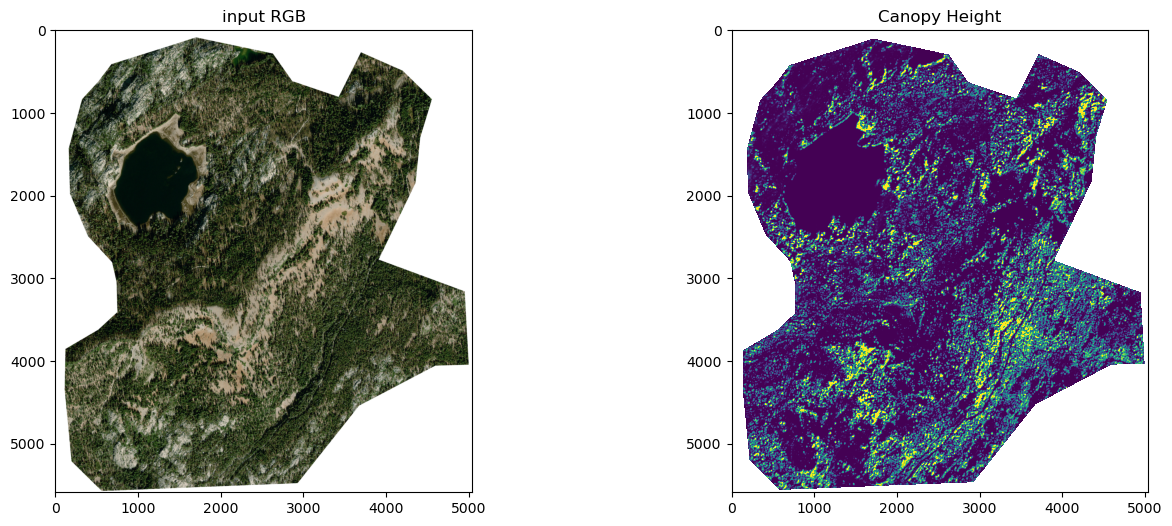

In [10]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')